# SECTION 1: Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi  # just to sanity-check the GPU

!pip install wandb -q
import wandb

USE_WANDB = True
WANDB_ENTITY = "nndl-project-F25"
WANDB_PROJECT = "Multihead-Classification-Competition"

if USE_WANDB:
  wandb.login()


from datetime import datetime
import os, zipfile, random

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# wandb run-naming schema
def make_run_name(base: str) -> str:
    """Create a unique run name with timestamp."""
    return f"{base}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# optional: for approximate reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


Mounted at /content/drive
Sun Dec 14 17:27:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             52W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+---------------------

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akseldkw (akseldkw07) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


# SECTION 2: Config & Paths

In [ ]:
DATA_ROOT = "/content/drive/MyDrive/NNDL-Project/Project Data"

# Local scratch space on the VM / Colab
LOCAL_DATA_ROOT = "/content/local_data"
os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)

train_zip_path = os.path.join(DATA_ROOT, "train_images.zip")
test_zip_path = os.path.join(DATA_ROOT, "test_images.zip")

# Unzip to LOCAL_DATA_ROOT instead of Drive
train_out_dir = os.path.join(LOCAL_DATA_ROOT, "train_images")
test_out_dir = os.path.join(LOCAL_DATA_ROOT, "test_images")

if not os.path.exists(train_out_dir):
    os.makedirs(train_out_dir, exist_ok=True)
    with zipfile.ZipFile(train_zip_path, "r") as z:
        z.extractall(train_out_dir)

if not os.path.exists(test_out_dir):
    os.makedirs(test_out_dir, exist_ok=True)
    with zipfile.ZipFile(test_zip_path, "r") as z:
        z.extractall(test_out_dir)

TRAIN_IMG_DIR = os.path.join(train_out_dir, "train_images")
TEST_IMG_DIR = os.path.join(test_out_dir, "test_images")

TRAIN_CSV = os.path.join(DATA_ROOT, "train_data.csv")
SUPER_CSV = os.path.join(DATA_ROOT, "superclass_mapping.csv")
SUB_CSV = os.path.join(DATA_ROOT, "subclass_mapping.csv")

BATCH_SIZE = 64
NUM_WORKERS = 2  # can set to 0 if we hit dataloader issues

VAL_SPLIT = 0.1  # 10% validation
IMG_SIZE = 64  # our image dimensions

PROJECT_NAME = "coms4776-transfer-learning"  # TBD update
APPROACH = "two_models"  # "two_heads" or "two_models"
DATA_AUGMENT = True

# Indices for "novel" classes (per provided data)
NOVEL_SUPER_IDX = 3  # superclass index for novel
NOVEL_SUB_IDX = 87  # subclass index for novel

# Number of times run full-batch
EPOCHS = 15

# Learning rates
LR = 1e-4  # overall learning rate
LR_HEAD = 1e-2  # head learning rate, used when freezing backbone
WEIGHT_DECAY = 1e-4  # seems standard
BACKBONE = "resnet50"  # "resnet18" or "resnet50"

# Novel-super CIFAR integration (more images)
# Options: "none", "small" (~1000 samples), "large" (~5000 samples)
CIFAR_NOVEL_MODE = "large"  # "large" or "small" or "none"

# Path to store metadata about CIFAR novel images
CIFAR_NOVEL_CSV_PATH = os.path.join(LOCAL_DATA_ROOT, "cifar_novel_data.csv")

# Fine-tuning mode for ResNet backbone
# "full"   = train all layers (what you're currently doing)
# "frozen" = freeze backbone, train only the heads on top
FINE_TUNE_MODE = "full"  # or "frozen"

# Initial novelty thresholds (starting points, will tune further)
TAU_SUPER = (
    0.99  # NOTE: per calibration with validation data. if max superclass prob < TAU_SUPER -> predict novel superclass
)
TAU_SUB = 0.85  # NOTE: per calibration with validation data. if max subclass prob < TAU_SUB  -> predict novel subclass

########### MAKE SURE USE_PSEDUO_NOVEL IS FALSE BEFORE LEADERBOARD SUBMISSION ##################################################
USE_PSEUDO_NOVEL = False  # to validate on held-out subclasses from training. Used to fine-tune TAU_SUB
PSEUDO_NOVEL_FRACTION = 0.15
PSEUDO_NOVEL_SEED = 123

In [ ]:
# Build CIFAR-100 novel-super dataset (excluding reptiles)
from torchvision.datasets import CIFAR100

# Download CIFAR100 once (raw PIL images)
CIFAR_ROOT = os.path.join(LOCAL_DATA_ROOT, "cifar100_raw")
os.makedirs(CIFAR_ROOT, exist_ok=True)

# Only do the heavy image-copying if CSV doesn't exist
if CIFAR_NOVEL_MODE != "none" and not os.path.exists(CIFAR_NOVEL_CSV_PATH):
    print("Building CIFAR novel-super dataset (this happens once)...")

    cifar_train = CIFAR100(root=CIFAR_ROOT, train=True, download=True, transform=None)

    # CIFAR-100 fine label names (with underscores)
    cifar_fine_names = cifar_train.classes  # e.g. "apple", "beaver", "aquarium_fish", ...

    # Fine classes we want, based on your list, excluding reptiles
    # (these names match CIFAR-100 fine label names)
    allowed_fine_names = set(
        [
            # aquatic mammals
            "beaver",
            "dolphin",
            "otter",
            "seal",
            "whale",
            # fish
            "aquarium_fish",
            "flatfish",
            "ray",
            "shark",
            "trout",
            # flowers
            "orchid",
            "poppy",
            "rose",
            "sunflower",
            "tulip",
            # food containers
            "bottle",
            "bowl",
            "can",
            "cup",
            "plate",
            # fruit and vegetables
            "apple",
            "mushroom",
            "orange",
            "pear",
            "sweet_pepper",
            # household electrical devices
            "clock",
            "keyboard",
            "lamp",
            "telephone",
            "television",
            # household furniture
            "bed",
            "chair",
            "couch",
            "table",
            "wardrobe",
            # insects
            "bee",
            "beetle",
            "butterfly",
            "caterpillar",
            "cockroach",
            # large carnivores
            "bear",
            "leopard",
            "lion",
            "tiger",
            "wolf",
            # large man-made outdoor things
            "bridge",
            "castle",
            "house",
            "road",
            "skyscraper",
            # large natural outdoor scenes
            "cloud",
            "forest",
            "mountain",
            "plain",
            "sea",
            # large omnivores and herbivores
            "camel",
            "cattle",
            "chimpanzee",
            "elephant",
            "kangaroo",
            # medium-sized mammals
            "fox",
            "porcupine",
            "possum",
            "raccoon",
            "skunk",
            # non-insect invertebrates
            "crab",
            "lobster",
            "snail",
            "spider",
            "worm",
            # people
            "baby",
            "boy",
            "girl",
            "man",
            "woman",
            # small mammals
            "hamster",
            "mouse",
            "rabbit",
            "shrew",
            "squirrel",
            # trees
            "maple",
            "oak",
            "palm",
            "pine",
            "willow",
            # vehicles 1
            "bicycle",
            "bus",
            "motorcycle",
            "pickup_truck",
            "train",
            # vehicles 2
            "lawn_mower",
            "rocket",
            "streetcar",
            "tank",
            "tractor",
            # NOTE: reptiles group ("crocodile", "dinosaur", "lizard", "snake", "turtle") is *excluded* on purpose
        ]
    )

    # Map class_name -> list of indices for that fine class
    name_to_indices = {name: [] for name in allowed_fine_names}
    for idx in range(len(cifar_train)):
        _, fine_label = cifar_train[idx]  # fine_label is int index into cifar_fine_names
        fine_name = cifar_fine_names[fine_label]
        if fine_name in allowed_fine_names:
            name_to_indices[fine_name].append(idx)

    # Flatten candidate indices across all allowed classes
    candidate_indices = []
    for name, idx_list in name_to_indices.items():
        candidate_indices.extend(idx_list)

    print("Total candidate CIFAR images (allowed classes, excl. reptiles):", len(candidate_indices))

    # Target total novel-super samples (max 5000, as you requested)
    TARGET_TOTAL = 5000
    random.seed(42)
    random.shuffle(candidate_indices)
    selected_indices = candidate_indices[:TARGET_TOTAL]

    print("Selected indices:", len(selected_indices))

    # Copy images into TRAIN_IMG_DIR and build CSV rows
    cifar_aug_records = []

    for idx in selected_indices:
        img, fine_label = cifar_train[idx]
        fine_name = cifar_fine_names[fine_label]

        # Unique filename to avoid collisions
        fname = f"cifar_novel_{idx}_{fine_name}.png"
        dst_path = os.path.join(TRAIN_IMG_DIR, fname)

        # img is PIL.Image when transform=None
        img.save(dst_path)

        record = {
            "image": fname,
            "superclass_index": NOVEL_SUPER_IDX,  # novel superclass
            "subclass_index": NOVEL_SUB_IDX,  # novel subclass
            "description": f"CIFAR100:{fine_name} (novel superclass)",
        }
        cifar_aug_records.append(record)

    cifar_aug_df = pd.DataFrame(cifar_aug_records)
    cifar_aug_df.to_csv(CIFAR_NOVEL_CSV_PATH, index=False)
    print("Saved CIFAR novel-super metadata to:", CIFAR_NOVEL_CSV_PATH)
    print("Images copied into TRAIN_IMG_DIR:", TRAIN_IMG_DIR)

elif CIFAR_NOVEL_MODE != "none":
    print("CIFAR novel-super CSV already exists at:", CIFAR_NOVEL_CSV_PATH)
else:
    print("CIFAR_NOVEL_MODE='none'; skipping CIFAR novel-super creation.")

Building CIFAR novel-super dataset (this happens once)...


100%|██████████| 169M/169M [00:13<00:00, 12.5MB/s]


Total candidate CIFAR images (allowed classes, excl. reptiles): 45000
Selected indices: 5000
Saved CIFAR novel-super metadata to: /content/local_data/cifar_novel_data.csv
Images copied into TRAIN_IMG_DIR: /content/local_data/train_images/train_images


# SECTION 3: Data Loading & DataLoaders

In [ ]:
# SECTION 3: Data Loading & Dataloaders

# Base training data from class
base_train_df = pd.read_csv(TRAIN_CSV)

super_map_df = pd.read_csv(SUPER_CSV)  # columns: index, class
sub_map_df = pd.read_csv(SUB_CSV)  # columns: index, class

num_super = len(super_map_df)
num_sub = len(sub_map_df)

print("Num superclasses:", num_super)
print("Num subclasses:", num_sub)

# --- Integrate CIFAR novel-super examples, if enabled ---

if CIFAR_NOVEL_MODE == "none":
    train_df = base_train_df.copy()
    print("CIFAR_NOVEL_MODE='none' → using only original training data.")
else:
    if not os.path.exists(CIFAR_NOVEL_CSV_PATH):
        raise FileNotFoundError(
            f"CIFAR_NOVEL_MODE={CIFAR_NOVEL_MODE} but {CIFAR_NOVEL_CSV_PATH} not found. "
            "Run the CIFAR novel-super build section first."
        )

    cifar_aug_df = pd.read_csv(CIFAR_NOVEL_CSV_PATH)

    if CIFAR_NOVEL_MODE == "small":
        # Use ~1000 CIFAR novel-super images
        n_small = min(1000, len(cifar_aug_df))
        cifar_aug_df = cifar_aug_df.sample(n=n_small, random_state=42).reset_index(drop=True)
        print(f"CIFAR_NOVEL_MODE='small' → using {len(cifar_aug_df)} CIFAR novel-super samples.")
    elif CIFAR_NOVEL_MODE == "large":
        # Use all available (up to 5000 created earlier)
        print(f"CIFAR_NOVEL_MODE='large' → using {len(cifar_aug_df)} CIFAR novel-super samples.")
    else:
        raise ValueError(f"Unknown CIFAR_NOVEL_MODE: {CIFAR_NOVEL_MODE}")

    # Combine original training data with CIFAR novel-super rows
    train_df = pd.concat([base_train_df, cifar_aug_df], ignore_index=True)
    print("Combined train_df size (original + CIFAR):", len(train_df))
    print(
        "  Novel-super count (superclass_index == NOVEL_SUPER_IDX):",
        (train_df["superclass_index"] == NOVEL_SUPER_IDX).sum(),
    )

# --- Build subclass -> superclass mapping from *combined* train_df ---
# This still satisfies “each subclass has a single superclass”:
#  - Original subclasses 0..86
#  - Novel subclass 87 always maps to NOVEL_SUPER_IDX
sub_to_super = train_df.groupby("subclass_index")["superclass_index"].agg(lambda x: x.value_counts().index[0]).to_dict()

print("Example sub_to_super mapping (first 10):", dict(list(sub_to_super.items())[:10]))

Num superclasses: 4
Num subclasses: 88
CIFAR_NOVEL_MODE='large' → using 5000 CIFAR novel-super samples.
Combined train_df size (original + CIFAR): 11288
  Novel-super count (superclass_index == NOVEL_SUPER_IDX): 5000
Example sub_to_super mapping (first 10): {0: 1, 1: 2, 2: 1, 3: 2, 4: 0, 5: 0, 6: 0, 7: 1, 8: 0, 9: 1}


In [5]:
# Dataset functions
class BirdDogReptileDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["image"]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        super_idx = int(row["superclass_index"])
        sub_idx = int(row["subclass_index"])
        return image, super_idx, sub_idx

In [ ]:
# Test dataset (for leaderboard predictions)


class BirdDogReptileTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        # assumes images are named 0.jpg, 1.jpg, ..., N-1.jpg
        self.filenames = sorted(os.listdir(img_dir), key=lambda x: int(os.path.splitext(x)[0]))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, img_name

In [ ]:
# Transforms

if DATA_AUGMENT:
    train_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
else:
    train_transform = transforms.Compose(
        [
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

val_test_transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
# Train/val split + loaders with optional pseudo-novel validation,
# ensuring novel-super examples (super == NOVEL_SUPER_IDX) appear in both train and val.

from math import ceil

pseudo_novel_loader = None  # default; will be set if USE_PSEUDO_NOVEL
heldout_subclasses = None  # to inspect later if needed


def split_seen_vs_novel_super(df, val_split, novel_super_idx, rng_seed=42):
    """
    Split dataframe into train/val, ensuring that both seen-super (0/1/2)
    and novel-super (== novel_super_idx) appear in both splits if present.
    """
    rng = np.random.default_rng(rng_seed)

    df_novel_super = df[df["superclass_index"] == novel_super_idx]
    df_seen_super = df[df["superclass_index"] != novel_super_idx]

    print("  Seen-super samples:", len(df_seen_super))
    print("  Novel-super samples:", len(df_novel_super))

    # Split seen-super part
    if len(df_seen_super) > 0:
        val_seen_size = int(len(df_seen_super) * val_split)
        val_seen_indices = rng.choice(len(df_seen_super), size=val_seen_size, replace=False)
        val_seen_df = df_seen_super.iloc[val_seen_indices]
        train_seen_df = df_seen_super.drop(val_seen_df.index)
    else:
        val_seen_df = df_seen_super.iloc[0:0]
        train_seen_df = df_seen_super.iloc[0:0]

    # Split novel-super part (if any)
    if len(df_novel_super) > 0:
        val_novel_size = max(1, int(len(df_novel_super) * val_split))
        val_novel_indices = rng.choice(len(df_novel_super), size=val_novel_size, replace=False)
        val_novel_df = df_novel_super.iloc[val_novel_indices]
        train_novel_df = df_novel_super.drop(val_novel_df.index)
    else:
        val_novel_df = df_novel_super.iloc[0:0]
        train_novel_df = df_novel_super.iloc[0:0]

    # Combine splits and shuffle
    train_split_df = pd.concat([train_seen_df, train_novel_df], ignore_index=True)
    val_split_df = pd.concat([val_seen_df, val_novel_df], ignore_index=True)

    train_split_df = train_split_df.sample(frac=1.0, random_state=rng_seed).reset_index(drop=True)
    val_split_df = val_split_df.sample(frac=1.0, random_state=rng_seed + 1).reset_index(drop=True)

    print("  Final split sizes:")
    print("    train:", len(train_split_df))
    print("    val:  ", len(val_split_df))
    print("    train novel-super:", (train_split_df["superclass_index"] == novel_super_idx).sum())
    print("    val novel-super:  ", (val_split_df["superclass_index"] == novel_super_idx).sum())

    return train_split_df, val_split_df


if not USE_PSEUDO_NOVEL:
    # -------------------------
    # Simple split, but novel-super-aware
    # -------------------------
    print("[Simple split, novel-super aware]")

    train_split_df, val_split_df = split_seen_vs_novel_super(
        train_df,
        VAL_SPLIT,
        NOVEL_SUPER_IDX,
        rng_seed=42,
    )

    train_dataset = BirdDogReptileDataset(
        train_split_df,
        TRAIN_IMG_DIR,
        transform=train_transform,
    )
    val_dataset = BirdDogReptileDataset(
        val_split_df,
        TRAIN_IMG_DIR,
        transform=val_test_transform,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    print(f"[Simple split] Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

else:
    # -------------------------
    # Pseudo-novel setup: hold out some subclasses entirely for pseudo-novel validation
    # while still keeping novel-super in both train and val.
    # -------------------------

    print("[Pseudo-novel subclass split + novel-super-aware train/val]")

    # 1) choose subset of subclasses to treat as pseudo-novel
    all_subclasses = sorted(train_df["subclass_index"].unique())
    # Do NOT hold out the novel subclass itself (87)
    all_subclasses_no_novel = [c for c in all_subclasses if c != NOVEL_SUB_IDX]

    rng = np.random.default_rng(PSEUDO_NOVEL_SEED)

    num_holdout = max(1, int(len(all_subclasses_no_novel) * PSEUDO_NOVEL_FRACTION))
    heldout_subclasses = set(rng.choice(all_subclasses_no_novel, size=num_holdout, replace=False).tolist())
    seen_subclasses = [c for c in all_subclasses if c not in heldout_subclasses]

    print(f"[Pseudo-novel] Total subclasses (excl. novel): {len(all_subclasses_no_novel)}")
    print(f"[Pseudo-novel] Held-out subclasses (pseudo-novel): {sorted(heldout_subclasses)}")
    print(f"[Pseudo-novel] Seen subclasses (incl. novel-sub): {len(seen_subclasses)}")

    # 2) split dataframe into seen vs pseudo-novel (by subclass)
    seen_mask = ~train_df["subclass_index"].isin(heldout_subclasses)
    seen_df = train_df[seen_mask].reset_index(drop=True)
    pseudo_novel_df = train_df[~seen_mask].reset_index(drop=True)

    print(f"[Pseudo-novel] Seen samples: {len(seen_df)}, Pseudo-novel samples: {len(pseudo_novel_df)}")

    # 3) Train/val split on seen data, but ensure novel-super in both
    train_split_df, val_split_df = split_seen_vs_novel_super(
        seen_df,
        VAL_SPLIT,
        NOVEL_SUPER_IDX,
        rng_seed=PSEUDO_NOVEL_SEED,
    )

    train_dataset = BirdDogReptileDataset(
        train_split_df,
        TRAIN_IMG_DIR,
        transform=train_transform,
    )
    val_seen_dataset = BirdDogReptileDataset(
        val_split_df,
        TRAIN_IMG_DIR,
        transform=val_test_transform,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_seen_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    # 4) pseudo-novel validation loader (all held-out subclasses, val-style transform)
    pseudo_novel_dataset = BirdDogReptileDataset(
        pseudo_novel_df,
        TRAIN_IMG_DIR,
        transform=val_test_transform,
    )
    pseudo_novel_loader = DataLoader(
        pseudo_novel_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    print(
        f"[Pseudo-novel] Train size: {len(train_dataset)}, "
        f"Seen-val size: {len(val_seen_dataset)}, "
        f"Pseudo-novel val size: {len(pseudo_novel_dataset)}"
    )

# Test loader is the same regardless
test_dataset = BirdDogReptileTestDataset(TEST_IMG_DIR, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
# change batch size back to 1 if see any errors

print(f"Test size: {len(test_dataset)}")

[Simple split, novel-super aware]
  Seen-super samples: 6288
  Novel-super samples: 5000
  Final split sizes:
    train: 10160
    val:   1128
    train novel-super: 4500
    val novel-super:   500
[Simple split] Train size: 10160, Val size: 1128
Test size: 11180


# SECTION 4: Backbone & Model Definitions

In [ ]:
# Backbone builder

# Using ImageNet pretrained ResNet backbone, and chopping off FC head to Transfer Learn


def build_resnet_backbone():
    # Using torchvision ResNet-18 with ImageNet weights
    if BACKBONE == "resnet18":
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    elif BACKBONE == "resnet50":
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    else:
        raise ValueError(f"Unknown BACKBONE: {BACKBONE}")
    # Remove the final classification layer
    in_features = base.fc.in_features
    base.fc = nn.Identity()
    return base, in_features

In [ ]:
# Methods for Shared backbone + two heads + KL divergence


class SharedBackboneTwoHeads(nn.Module):
    def __init__(self, num_super, num_sub):
        super().__init__()
        self.backbone, feat_dim = build_resnet_backbone()
        self.super_head = nn.Linear(feat_dim, num_super)
        self.sub_head = nn.Linear(feat_dim, num_sub)

    def forward(self, x):
        feats = self.backbone(x)
        super_logits = self.super_head(feats)
        sub_logits = self.sub_head(feats)
        return super_logits, sub_logits

In [ ]:
# KL helper that maps subclass probs to superclass probs using sub_to_super mapping


def sub_probs_to_super_probs(sub_probs, sub_to_super, num_super):
    """
    sub_probs: (B, num_sub), softmax over subclasses
    returns: (B, num_super), summed probs per super-class
    """
    B, num_sub = sub_probs.shape
    super_probs = torch.zeros(B, num_super, device=sub_probs.device)

    for sub_idx, super_idx in sub_to_super.items():
        super_probs[:, super_idx] += sub_probs[:, sub_idx]

    # For safety: re-normalize in case of any numeric drift
    super_probs = super_probs / (super_probs.sum(dim=1, keepdim=True) + 1e-8)
    return super_probs

In [ ]:
# Single-head model for 2-separate models approach
# Each model is just a backbone + one linear head

# to instantiate, one has num_classes = num_super, other has num_classes = num_sub


class SingleHeadModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone, feat_dim = build_resnet_backbone()
        self.head = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        logits = self.head(feats)
        return logits

# SECTION 5: Training & evaluation utilities

In [ ]:
# functions for training

# we pass a flag mode to indicate which model using either:
# "two_heads_kl", "single_head_super" or "single_head"sub"


def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total


def train_one_epoch(
    model, optimizer, loader, criterion, mode, sub_to_super=None, num_super=None, alpha_kl=0.1, temperature=1.0
):
    model.train()
    running_loss = 0.0
    super_correct = sub_correct = 0
    super_total = sub_total = 0

    for images, super_labels, sub_labels in loader:
        images = images.to(device)
        super_labels = super_labels.to(device)
        sub_labels = sub_labels.to(device)

        optimizer.zero_grad()

        if mode == "two_heads_kl":
            super_logits, sub_logits = model(images)
            # CE losses
            loss_super = criterion(super_logits, super_labels)
            loss_sub = criterion(sub_logits, sub_labels)

            # KL term between super head and aggregated subclass head
            with torch.no_grad():
                # target: super_probs
                super_probs = F.softmax(super_logits / temperature, dim=1)
            sub_probs = F.softmax(sub_logits / temperature, dim=1)
            agg_super_probs = sub_probs_to_super_probs(sub_probs, sub_to_super, num_super)

            # KL(super || agg_super) = sum p * (log p - log q)
            # using KLDivLoss with log_softmax input and probs target:
            kl_loss = F.kl_div(input=torch.log(agg_super_probs + 1e-8), target=super_probs, reduction="batchmean")

            loss = loss_super + loss_sub + alpha_kl * kl_loss

            sc, st = accuracy_from_logits(super_logits, super_labels)
            suc, sut = accuracy_from_logits(sub_logits, sub_labels)
            super_correct += sc
            super_total += st
            sub_correct += suc
            sub_total += sut

        elif mode in ("single_head_super", "single_head_sub"):
            logits = model(images)
            if mode == "single_head_super":
                loss = criterion(logits, super_labels)
                sc, st = accuracy_from_logits(logits, super_labels)
                super_correct += sc
                super_total += st
            else:
                loss = criterion(logits, sub_labels)
                suc, sut = accuracy_from_logits(logits, sub_labels)
                sub_correct += suc
                sub_total += sut
        else:
            raise ValueError(f"Unknown mode {mode}")

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    metrics = {"loss": avg_loss}
    if super_total > 0:
        metrics["acc_super"] = super_correct / super_total
    if sub_total > 0:
        metrics["acc_sub"] = sub_correct / sub_total

    return metrics


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, mode, sub_to_super=None, num_super=None, alpha_kl=0.1, temperature=1.0):
    model.eval()
    running_loss = 0.0
    super_correct = sub_correct = 0
    super_total = sub_total = 0

    for images, super_labels, sub_labels in loader:
        images = images.to(device)
        super_labels = super_labels.to(device)
        sub_labels = sub_labels.to(device)

        if mode == "two_heads_kl":
            super_logits, sub_logits = model(images)
            loss_super = criterion(super_logits, super_labels)
            loss_sub = criterion(sub_logits, sub_labels)

            with torch.no_grad():
                super_probs = F.softmax(super_logits / temperature, dim=1)
            sub_probs = F.softmax(sub_logits / temperature, dim=1)
            agg_super_probs = sub_probs_to_super_probs(sub_probs, sub_to_super, num_super)

            kl_loss = F.kl_div(input=torch.log(agg_super_probs + 1e-8), target=super_probs, reduction="batchmean")

            loss = loss_super + loss_sub + alpha_kl * kl_loss

            sc, st = accuracy_from_logits(super_logits, super_labels)
            suc, sut = accuracy_from_logits(sub_logits, sub_labels)
            super_correct += sc
            super_total += st
            sub_correct += suc
            sub_total += sut

        elif mode in ("single_head_super", "single_head_sub"):
            logits = model(images)
            if mode == "single_head_super":
                loss = criterion(logits, super_labels)
                sc, st = accuracy_from_logits(logits, super_labels)
                super_correct += sc
                super_total += st
            else:
                loss = criterion(logits, sub_labels)
                suc, sut = accuracy_from_logits(logits, sub_labels)
                sub_correct += suc
                sub_total += sut

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    metrics = {"val_loss": avg_loss}
    if super_total > 0:
        metrics["val_acc_super"] = super_correct / super_total
    if sub_total > 0:
        metrics["val_acc_sub"] = sub_correct / sub_total

    return metrics

In [ ]:
# Analysis and Visualize: for Novel Subclass fine tuning
# Determines optimal threshold value from training data (except held out) vs. held out (pseudo-novel) subclass data


@torch.no_grad()
def collect_max_probs_sub(model, loader, mode="two_heads"):
    """
    Collect max softmax probabilities from the subclass head.

    mode:
      - "two_heads": model(images) -> (super_logits, sub_logits)
      - "sub_single_head": model(images) -> sub_logits
    """
    model.eval()
    probs = []

    for batch in loader:
        images = batch[0].to(device)

        if mode == "two_heads":
            _, sub_logits = model(images)
        elif mode == "sub_single_head":
            sub_logits = model(images)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        # Softmax over subclasses, then take max per sample
        p = F.softmax(sub_logits, dim=1).max(dim=1).values
        probs.extend(p.cpu().numpy().tolist())

    return np.array(probs)


@torch.no_grad()
def analyze_tau_sub(model, mode="two_heads"):
    """
    Compare max subclass probabilities on:
      - seen validation (val_loader)
      - pseudo-novel validation (pseudo_novel_loader)
    and suggest TAU_SUB candidates.
    """

    if pseudo_novel_loader is None:
        print(
            "pseudo_novel_loader is None. " "Set USE_PSEUDO_NOVEL = True before building loaders to use this analysis."
        )
        return

    # Collect max probs
    seen_probs = collect_max_probs_sub(model, val_loader, mode=mode)
    pseudo_probs = collect_max_probs_sub(model, pseudo_novel_loader, mode=mode)

    # Summary stats
    def summarize(name, arr):
        print(f"\n{name} subclass max-prob stats:")
        print(f"  count = {len(arr)}")
        print(f"  mean  = {arr.mean():.3f}")
        print(f"  std   = {arr.std():.3f}")
        percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
        pvals = {p: float(np.percentile(arr, p)) for p in percentiles}
        print("  percentiles:")
        for p in percentiles:
            print(f"    p{p:>2}: {pvals[p]:.3f}")
        return pvals

    seen_p = summarize("Seen", seen_probs)
    pseudo_p = summarize("Pseudo-novel", pseudo_probs)

    # Simple candidate thresholds
    # 1) 10th percentile of seen (reject only the lowest-confidence seen examples)
    tau_candidate_1 = seen_p[10]

    # 2) Midpoint between mean(seen) and mean(pseudo)
    tau_candidate_2 = 0.5 * (seen_probs.mean() + pseudo_probs.mean())

    print("\nSuggested TAU_SUB candidates:")
    print(f"  tau_sub ≈ 10th percentile of seen: {tau_candidate_1:.3f}")
    print(f"  tau_sub ≈ mean(seen + pseudo)/2:  {tau_candidate_2:.3f}")
    print("\nYou can start with one of these for TAU_SUB and adjust based on leaderboard/behavior.")

    # Histogram visualization
    plt.figure(figsize=(8, 5))
    plt.hist(seen_probs, bins=30, alpha=0.5, label="Seen subclasses")
    plt.hist(pseudo_probs, bins=30, alpha=0.5, label="Pseudo-novel subclasses")
    plt.axvline(tau_candidate_1, linestyle="--", label=f"p10 seen ~ {tau_candidate_1:.2f}")
    plt.axvline(tau_candidate_2, linestyle=":", label=f"mean midpoint ~ {tau_candidate_2:.2f}")
    plt.xlabel("Max softmax probability (subclass head)")
    plt.ylabel("Count")
    plt.title("Subclass max-prob: seen vs pseudo-novel")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: log histograms and candidates to W&B
    if USE_WANDB:
        try:
            import wandb

            wandb.log(
                {
                    "sub_seen_maxprob_hist": wandb.Histogram(seen_probs),
                    "sub_pseudo_maxprob_hist": wandb.Histogram(pseudo_probs),
                    "tau_sub_candidate_p10_seen": tau_candidate_1,
                    "tau_sub_candidate_mean_midpoint": tau_candidate_2,
                }
            )
            print("Logged histograms and tau_sub candidates to Weights & Biases.")
        except Exception as e:
            print("Could not log to W&B:", e)

In [ ]:
# Analysis and Visualize: for Novel Superclass fine tuning
# Determines the optimal threshold from provided training data vs. Novel Super data (more images)


@torch.no_grad()
def collect_max_probs_super(model, loader, mode="two_heads"):
    """
    Collect max softmax probabilities from the superclass head.

    mode:
      - "two_heads": model(images) -> (super_logits, sub_logits)
      - "super_single_head": model(images) -> super_logits
    """
    model.eval()
    probs = []

    for batch in loader:
        images = batch[0].to(device)

        if mode == "two_heads":
            super_logits, _ = model(images)
        elif mode == "super_single_head":
            super_logits = model(images)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        p = F.softmax(super_logits, dim=1).max(dim=1).values
        probs.extend(p.cpu().numpy().tolist())

    return np.array(probs)


@torch.no_grad()
def analyze_tau_super(model, mode="two_heads"):
    """
    Analyze max superclass probabilities on validation set, split into:
      - seen superclasses (super != NOVEL_SUPER_IDX)
      - novel superclasses (super == NOVEL_SUPER_IDX)

    This assumes:
      - val_loader batches look like (images, super_labels, sub_labels, ...)
      - NOVEL_SUPER_IDX is defined (e.g. 3)
    """

    model.eval()

    seen_probs = []
    novel_probs = []

    for batch in val_loader:
        images = batch[0].to(device)
        super_labels = batch[1].to(device)  # assumes (images, super, sub, ...)

        # Forward
        if mode == "two_heads":
            super_logits, _ = model(images)
        elif mode == "super_single_head":
            super_logits = model(images)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        probs = F.softmax(super_logits, dim=1)  # (B, num_super)
        max_probs, _ = probs.max(dim=1)  # (B,)

        novel_mask = super_labels == NOVEL_SUPER_IDX
        seen_mask = ~novel_mask

        if seen_mask.any():
            seen_probs.extend(max_probs[seen_mask].detach().cpu().numpy().tolist())
        if novel_mask.any():
            novel_probs.extend(max_probs[novel_mask].detach().cpu().numpy().tolist())

    seen_probs = np.array(seen_probs)
    novel_probs = np.array(novel_probs)

    def summarize(name, arr):
        print(f"\n{name} superclass max-prob stats:")
        print(f"  count = {len(arr)}")
        print(f"  mean  = {arr.mean():.3f}")
        print(f"  std   = {arr.std():.3f}")
        percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
        pvals = {p: float(np.percentile(arr, p)) for p in percentiles}
        print("  percentiles:")
        for p in percentiles:
            print(f"    p{p:>2}: {pvals[p]:.3f}")
        return pvals

    if len(seen_probs) == 0:
        print("No seen-super examples found in val_loader (super != NOVEL_SUPER_IDX).")
        return
    seen_p = summarize("Seen superclasses (0/1/2)", seen_probs)

    if len(novel_probs) == 0:
        print("\nNo novel-super examples (super == NOVEL_SUPER_IDX) in val_loader yet.")
        novel_p = None
    else:
        novel_p = summarize("Novel superclasses (== NOVEL_SUPER_IDX)", novel_probs)

    # ---- Candidate thresholds ----
    # Start from seen distribution:
    tau_p10_seen = seen_p[10]
    tau_p5_seen = seen_p[5]
    tau_mean_minus_std = max(0.0, min(1.0, seen_probs.mean() - seen_probs.std()))

    # If we have novel-super stats, try to place tau between seen & novel means/percentiles
    if novel_p is not None:
        # Midpoint between seen mean and novel mean
        tau_mean_mid = 0.5 * (seen_probs.mean() + novel_probs.mean())
        print("\nSuggested TAU_SUPER candidates (using seen + novel):")
        print(f"  tau_super ≈ 10th percentile of seen:       {tau_p10_seen:.3f}")
        print(f"  tau_super ≈ 5th percentile of seen:        {tau_p5_seen:.3f}")
        print(f"  tau_super ≈ mean(seen) - std(seen):        {tau_mean_minus_std:.3f}")
        print(f"  tau_super ≈ mean(seen & novel) midpoint:   {tau_mean_mid:.3f}")
        tau_candidates = [tau_p10_seen, tau_p5_seen, tau_mean_minus_std, tau_mean_mid]
    else:
        print("\nSuggested TAU_SUPER candidates (seen only):")
        print(f"  tau_super ≈ 10th percentile of seen:       {tau_p10_seen:.3f}")
        print(f"  tau_super ≈ 5th percentile of seen:        {tau_p5_seen:.3f}")
        print(f"  tau_super ≈ mean(seen) - std(seen):        {tau_mean_minus_std:.3f}")
        tau_candidates = [tau_p10_seen, tau_p5_seen, tau_mean_minus_std]

    # ---- Histogram plot ----
    plt.figure(figsize=(8, 5))
    plt.hist(seen_probs, bins=30, alpha=0.6, label="Seen superclasses (0/1/2)")
    if len(novel_probs) > 0:
        plt.hist(novel_probs, bins=30, alpha=0.6, label="Novel superclasses (3)")

    # Draw candidate lines (use a couple of them for visual reference)
    for tau in tau_candidates[:3]:
        plt.axvline(tau, linestyle="--", alpha=0.7)

    plt.xlabel("Max softmax probability (superclass head)")
    plt.ylabel("Count")
    plt.title("Superclass max-prob: seen vs novel-super on validation")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Optional: log to W&B ----
    if USE_WANDB:
        try:
            import wandb

            log_dict = {
                "super_seen_maxprob_hist": wandb.Histogram(seen_probs),
            }
            if len(novel_probs) > 0:
                log_dict["super_novel_maxprob_hist"] = wandb.Histogram(novel_probs)
            # Also log first few tau candidates
            log_dict["tau_super_candidate_1"] = float(tau_candidates[0])
            if len(tau_candidates) > 1:
                log_dict["tau_super_candidate_2"] = float(tau_candidates[1])
            if len(tau_candidates) > 2:
                log_dict["tau_super_candidate_3"] = float(tau_candidates[2])
            wandb.log(log_dict)
            print("Logged superclass histograms and tau_super candidates to Weights & Biases.")
        except Exception as e:
            print("Could not log to W&B:", e)

In [ ]:
# Additional eval helper functions

# This calculates the following:
# 1. How often we correctly keep seen classes (low false "novel" rate)
# 2. How often we correctly identify CIFAR "novel super" samples (new data)


@torch.no_grad()
def evaluate_on_val_with_novelty(
    model, mode="two_heads", tau_super=TAU_SUPER, tau_sub=TAU_SUB, loader=None, name="val"
):
    """
    Evaluate a model on a loader with novel thresholds applied.

    For subclasses, we ONLY care about:
      - overall subclass acc
      - seen-subclass acc / false-novel rate

    We DO NOT report "novel-subclass accuracy" here because there are no
    ground-truth novel-sub labels in the original validation data.
    """
    if loader is None:
        loader = val_loader

    model.eval()

    total = 0
    super_correct = 0
    sub_correct = 0

    seen_super_correct = seen_super_total = 0
    novel_super_correct = novel_super_total = 0

    seen_sub_correct = seen_sub_total = 0
    novel_sub_correct = novel_sub_total = 0  # still counted but not reported

    for batch in loader:
        images = batch[0].to(device)
        super_true = batch[1].to(device)
        sub_true = batch[2].to(device)

        if mode == "two_heads":
            super_logits, sub_logits = model(images)
        elif mode == "super_single_head":
            super_logits = model(images)
            sub_logits = None
        elif mode == "sub_single_head":
            super_logits = None
            sub_logits = model(images)
        else:
            raise ValueError(f"Unknown mode: {mode}")

        batch_size = images.size(0)
        total += batch_size

        # --- Superclass ---
        if super_logits is not None:
            super_probs = F.softmax(super_logits, dim=1)
            max_super_probs, super_idx = super_probs.max(dim=1)

            super_pred = super_idx.clone()
            novel_mask_super = max_super_probs < tau_super
            super_pred[novel_mask_super] = NOVEL_SUPER_IDX

            match_super = super_pred == super_true
            super_correct += match_super.sum().item()

            seen_mask_super = super_true != NOVEL_SUPER_IDX
            novel_mask_super_label = super_true == NOVEL_SUPER_IDX

            if seen_mask_super.any():
                seen_super_correct += match_super[seen_mask_super].sum().item()
                seen_super_total += seen_mask_super.sum().item()
            if novel_mask_super_label.any():
                novel_super_correct += match_super[novel_mask_super_label].sum().item()
                novel_super_total += novel_mask_super_label.sum().item()

        # --- Subclass ---
        if sub_logits is not None:
            sub_probs = F.softmax(sub_logits, dim=1)
            max_sub_probs, sub_idx = sub_probs.max(dim=1)

            sub_pred = sub_idx.clone()
            novel_mask_sub = max_sub_probs < tau_sub
            sub_pred[novel_mask_sub] = NOVEL_SUB_IDX

            match_sub = sub_pred == sub_true
            sub_correct += match_sub.sum().item()

            seen_mask_sub = sub_true != NOVEL_SUB_IDX
            novel_mask_sub_label = sub_true == NOVEL_SUB_IDX

            if seen_mask_sub.any():
                seen_sub_correct += match_sub[seen_mask_sub].sum().item()
                seen_sub_total += seen_mask_sub.sum().item()
            if novel_mask_sub_label.any():
                # counted but not reported; there shouldn't be any in original val
                novel_sub_correct += match_sub[novel_mask_sub_label].sum().item()
                novel_sub_total += novel_mask_sub_label.sum().item()

    # ----- Compute metrics dict -----
    metrics = {}

    if total > 0:
        if super_correct > 0 or seen_super_total + novel_super_total > 0:
            metrics["overall_super_acc"] = super_correct / total
        if sub_correct > 0 or seen_sub_total + novel_sub_total > 0:
            metrics["overall_sub_acc"] = sub_correct / total

    if seen_super_total > 0:
        metrics["seen_super_acc"] = seen_super_correct / seen_super_total
        metrics["seen_super_false_novel"] = 1.0 - metrics["seen_super_acc"]
    if novel_super_total > 0:
        metrics["novel_super_acc"] = novel_super_correct / novel_super_total

    if seen_sub_total > 0:
        metrics["seen_sub_acc"] = seen_sub_correct / seen_sub_total
        metrics["seen_sub_false_novel"] = 1.0 - metrics["seen_sub_acc"]
    # NOTE: we deliberately do NOT add novel-sub metrics to `metrics`,
    # because they are not meaningful for this dataset.

    # ----- Print summary -----
    print(f"\n=== Evaluation on {name} ===")
    if "overall_super_acc" in metrics:
        print(f"Overall superclass acc: {metrics['overall_super_acc']:.4f}")
    if "overall_sub_acc" in metrics:
        print(f"Overall subclass acc:   {metrics['overall_sub_acc']:.4f}")

    if "seen_super_acc" in metrics:
        print(f"Seen superclass acc (true super != novel):   {metrics['seen_super_acc']:.4f}")
        print(f"Seen superclass false-novel rate:            {metrics['seen_super_false_novel']:.4f}")
    if "novel_super_acc" in metrics:
        print(f"Novel superclass acc (true super == novel):  {metrics['novel_super_acc']:.4f}")

    if "seen_sub_acc" in metrics:
        print(f"Seen subclass acc (true sub != novel):       {metrics['seen_sub_acc']:.4f}")
        print(f"Seen subclass false-novel rate:              {metrics['seen_sub_false_novel']:.4f}")

    # ----- Optional: log to W&B (only real metrics) -----
    if USE_WANDB:
        log_dict = {}
        for k, v in metrics.items():
            log_dict[f"{name}_{k}"] = v
        if log_dict:
            wandb.log(log_dict)

    return metrics


# This enables us to evaluate how often we correctly mark held-out subclasses as novel (proxy for leaderboard performance on subclasses)
@torch.no_grad()
def evaluate_pseudo_novel_sub_with_novelty(
    model, mode="two_heads", tau_sub=TAU_SUB, loader=None, name="pseudo_novel_sub"
):
    """
    Evaluate how well the model flags held-out subclasses as novel.

    Assumes:
      - loader yields only *held-out* subclasses (true unseen subclasses)
      - true labels are NOT NOVEL_SUB_IDX, but we *want* the model to predict NOVEL_SUB_IDX.
    """
    if loader is None:
        loader = pseudo_novel_loader

    if loader is None:
        print("No pseudo_novel_loader available.")
        return {}

    model.eval()

    total = 0
    predicted_novel = 0
    predicted_seen = 0

    for batch in loader:
        images = batch[0].to(device)
        # we don't actually need the labels here for correctness, only for counting

        if mode == "two_heads":
            _, sub_logits = model(images)
        elif mode == "sub_single_head":
            sub_logits = model(images)
        else:
            raise ValueError(f"Unknown mode for pseudo-novel eval: {mode}")

        sub_probs = F.softmax(sub_logits, dim=1)
        max_sub_probs, sub_idx = sub_probs.max(dim=1)

        sub_pred = sub_idx.clone()
        novel_mask_sub = max_sub_probs < tau_sub
        sub_pred[novel_mask_sub] = NOVEL_SUB_IDX

        batch_size = images.size(0)
        total += batch_size

        predicted_novel += (sub_pred == NOVEL_SUB_IDX).sum().item()
        predicted_seen += (sub_pred != NOVEL_SUB_IDX).sum().item()

    metrics = {}
    if total > 0:
        metrics["pseudo_novel_sub_novel_rate"] = predicted_novel / total
        metrics["pseudo_novel_sub_false_seen"] = predicted_seen / total

    print(f"\n=== Evaluation on {name} (held-out subclasses) ===")
    if total > 0:
        print(f"Fraction flagged as novel (good): {metrics['pseudo_novel_sub_novel_rate']:.4f}")
        print(f"Fraction mapped to seen subclasses (bad): {metrics['pseudo_novel_sub_false_seen']:.4f}")

    if USE_WANDB and metrics:
        log_dict = {f"{name}_{k}": v for k, v in metrics.items()}
        wandb.log(log_dict)

    return metrics

In [ ]:
# Dashboard for our evals so we can determine how model will likely perform on leaderboard evaluation


@torch.no_grad()
def novelty_dashboard(model, mode="two_heads", tau_super=TAU_SUPER, tau_sub=TAU_SUB, include_pseudo=True):
    """
    Run thresholded evals and show a compact table of key metrics.

    Subclass side focuses on:
      - seen subclasses (false-novel rate)
      - held-out pseudo-novel subclasses (how often marked as novel)
    """
    rows = []

    # --- Main val_loader stats (seen + CIFAR-novel) ---
    val_metrics = evaluate_on_val_with_novelty(
        model,
        mode=mode,
        tau_super=tau_super,
        tau_sub=tau_sub,
        loader=val_loader,
        name="val",
    )

    # Superclass (val)
    if "seen_super_acc" in val_metrics:
        rows.append(
            {
                "Split": "val",
                "Head": "super",
                "Metric": "Seen superclass accuracy",
                "Meaning": "Correctly keep seen superclasses as seen",
                "Value": float(val_metrics["seen_super_acc"]),
            }
        )
        if "seen_super_false_novel" in val_metrics:
            rows.append(
                {
                    "Split": "val",
                    "Head": "super",
                    "Metric": "Seen superclass false-novel rate",
                    "Meaning": "Seen superclasses incorrectly flipped to novel",
                    "Value": float(val_metrics["seen_super_false_novel"]),
                }
            )

    if "novel_super_acc" in val_metrics:
        rows.append(
            {
                "Split": "val",
                "Head": "super",
                "Metric": "Novel superclass accuracy (CIFAR)",
                "Meaning": "CIFAR novel-super samples correctly predicted as novel",
                "Value": float(val_metrics["novel_super_acc"]),
            }
        )

    # Subclass (val) — ONLY seen-subclass metrics
    if "seen_sub_acc" in val_metrics:
        rows.append(
            {
                "Split": "val",
                "Head": "sub",
                "Metric": "Seen subclass accuracy",
                "Meaning": "Correctly keep seen subclasses as seen",
                "Value": float(val_metrics["seen_sub_acc"]),
            }
        )
        if "seen_sub_false_novel" in val_metrics:
            rows.append(
                {
                    "Split": "val",
                    "Head": "sub",
                    "Metric": "Seen subclass false-novel rate",
                    "Meaning": "Seen subclasses incorrectly flipped to novel",
                    "Value": float(val_metrics["seen_sub_false_novel"]),
                }
            )
    # NOTE: we deliberately do NOT add a "novel subclass accuracy" row here.

    # --- Pseudo-novel subclass stats (held-out subclasses) ---
    pseudo_metrics = {}
    if include_pseudo and pseudo_novel_loader is not None and mode in ("two_heads", "sub_single_head"):
        pseudo_metrics = evaluate_pseudo_novel_sub_with_novelty(
            model,
            mode=mode,
            tau_sub=tau_sub,
            loader=pseudo_novel_loader,
            name="pseudo_novel_sub",
        )

        if "pseudo_novel_sub_novel_rate" in pseudo_metrics:
            rows.append(
                {
                    "Split": "pseudo_novel",
                    "Head": "sub",
                    "Metric": "Pseudo-novel marked as novel",
                    "Meaning": "Held-out subclasses correctly flagged as novel",
                    "Value": float(pseudo_metrics["pseudo_novel_sub_novel_rate"]),
                }
            )
        if "pseudo_novel_sub_false_seen" in pseudo_metrics:
            rows.append(
                {
                    "Split": "pseudo_novel",
                    "Head": "sub",
                    "Metric": "Pseudo-novel mapped to seen",
                    "Meaning": "Held-out subclasses wrongly mapped to some seen subclass",
                    "Value": float(pseudo_metrics["pseudo_novel_sub_false_seen"]),
                }
            )

    # --- Config / settings summary (for *printing* only) ---
    config_rows = [
        {
            "Split": "config",
            "Head": "-",
            "Metric": "BACKBONE",
            "Meaning": "Feature extractor (e.g. resnet18 / resnet50)",
            "Value": BACKBONE,
        },
        {
            "Split": "config",
            "Head": "-",
            "Metric": "TAU_SUPER",
            "Meaning": "Novelty threshold for superclass head",
            "Value": str(tau_super),
        },
        {
            "Split": "config",
            "Head": "-",
            "Metric": "TAU_SUB",
            "Meaning": "Novelty threshold for subclass head",
            "Value": str(tau_sub),
        },
        {
            "Split": "config",
            "Head": "-",
            "Metric": "CIFAR_NOVEL_MODE",
            "Meaning": "Extra novel-super CIFAR data mode",
            "Value": str(CIFAR_NOVEL_MODE),
        },
        {
            "Split": "config",
            "Head": "-",
            "Metric": "FINE_TUNE_MODE",
            "Meaning": "Backbone training mode (full vs frozen)",
            "Value": str(FINE_TUNE_MODE),
        },
        {
            "Split": "config",
            "Head": "-",
            "Metric": "APPROACH",
            "Meaning": "Model architecture (two_heads vs two_models)",
            "Value": str(APPROACH),
        },
        {
            "Split": "config",
            "Head": "-",
            "Metric": "USE_PSEUDO_NOVEL",
            "Meaning": "Using held-out subclasses for pseudo-novel eval",
            "Value": str(bool(USE_PSEUDO_NOVEL)),
        },
        {
            "Split": "config",
            "Head": "-",
            "Metric": "DATA_AUGMENT",
            "Meaning": "Whether data augmentation is enabled for training",
            "Value": str(bool(DATA_AUGMENT)),
        },
    ]

    rows.extend(config_rows)

    if not rows:
        print("No metrics to display in dashboard.")
        return None

    dashboard_df = pd.DataFrame(rows)
    dashboard_df = dashboard_df.sort_values(by=["Split", "Head", "Metric"]).reset_index(drop=True)

    print("\n==== Novelty Dashboard ====")
    print(dashboard_df)

    # --- Log to W&B: metrics only, numeric Value column ---
    if USE_WANDB:
        try:
            wandb_table_df = dashboard_df.copy()

            def _to_str(v):
                if isinstance(v, float):
                    return f"{v:.6f}"
                return str(v)

            wandb_table_df["Split"] = wandb_table_df["Split"].astype(str)
            wandb_table_df["Head"] = wandb_table_df["Head"].astype(str)
            wandb_table_df["Metric"] = wandb_table_df["Metric"].astype(str)
            wandb_table_df["Meaning"] = wandb_table_df["Meaning"].astype(str)
            wandb_table_df["Value"] = wandb_table_df["Value"].apply(_to_str)

            wandb.log({"novelty_dashboard": wandb.Table(dataframe=wandb_table_df)})
        except Exception as e:
            print("Could not log dashboard table to W&B:", e)

    return dashboard_df

In [ ]:
# Helper to choose backbone (freeze or full) and choose optimizer parameter


def setup_backbone_training(model, fine_tune_mode="full", lr_full=1e-4, lr_head=1e-3):
    """
    Given a model with attributes:
        - model.backbone  (all feature extractor layers)
        - head layers (e.g. super/sub heads) as other modules,
    freeze or unfreeze the backbone and return an optimizer.

    Returns:
        optimizer, effective_lr
    """
    if fine_tune_mode == "full":
        # Everything trainable
        for p in model.parameters():
            p.requires_grad = True
        trainable_params = model.parameters()
        lr = lr_full
    elif fine_tune_mode == "frozen":
        # Freeze backbone, train only heads
        for p in model.backbone.parameters():
            p.requires_grad = False
        # Only parameters that still require grad will be optimized
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        lr = lr_head
        print(f"Freezing backbone; training {len(trainable_params)} parameter tensors in heads only.")
    else:
        raise ValueError(f"Unknown FINE_TUNE_MODE: {fine_tune_mode}")

    optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=WEIGHT_DECAY)
    return optimizer

# SECTION 6: Approach A: Shared backbone, two heads + KL

In [ ]:
# Original idea

LR = 1e-4  # maybe two different learning rates
ALPHA_KL = 0.1
TEMPERATURE = 1.0

if APPROACH == "two_heads":
    model_two_heads = SharedBackboneTwoHeads(num_super=num_super, num_sub=num_sub).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = setup_backbone_training(
        model_two_heads,
        fine_tune_mode=FINE_TUNE_MODE,
        lr_full=LR,
        lr_head=LR_HEAD,
    )

    run_two_heads = None
    if USE_WANDB:
        run_two_heads = wandb.init(
            entity=WANDB_ENTITY,
            project=WANDB_PROJECT,
            name=make_run_name("two_heads_kl_resnet"),
            group="two_heads",  # to group/filter all two_heads runs
            config={
                "approach": "two_heads_kl",
                "backbone": BACKBONE,
                "epochs": EPOCHS,
                "lr_full": LR,
                "lr_head": LR_HEAD,
                "fine_tune_mode": FINE_TUNE_MODE,
                "alpha_kl": ALPHA_KL,
                "temperature": TEMPERATURE,
                "img_size": IMG_SIZE,
            },
        )

    best_val_score = 0.0

    print("Training shared-backbone two-heads model (KL-coupled):")
    for epoch in range(1, EPOCHS + 1):
        train_metrics = train_one_epoch(
            model_two_heads,
            optimizer,
            train_loader,
            criterion,
            mode="two_heads_kl",
            sub_to_super=sub_to_super,
            num_super=num_super,
            alpha_kl=ALPHA_KL,
            temperature=TEMPERATURE,
        )

        val_metrics = eval_one_epoch(
            model_two_heads,
            val_loader,
            criterion,
            mode="two_heads_kl",
            sub_to_super=sub_to_super,
            num_super=num_super,
            alpha_kl=ALPHA_KL,
            temperature=TEMPERATURE,
        )

        val_acc_super = val_metrics.get("val_acc_super", 0.0)
        val_acc_sub = val_metrics.get("val_acc_sub", 0.0)
        val_loss = val_metrics["val_loss"]

        print(
            f"[Two-heads] Epoch {epoch}: "
            f"train_loss={train_metrics['loss']:.4f}, "
            f"val_loss={val_loss:.4f}, "
            f"val_acc_super={val_acc_super:.4f}, "
            f"val_acc_sub={val_acc_sub:.4f}"
        )

        if USE_WANDB:
            # prefix metrics so they don't collide with two-model ones
            log_dict = {
                "epoch": epoch,
                "two_heads_train_loss": train_metrics["loss"],
                "two_heads_val_loss": val_loss,
                "two_heads_val_acc_super": val_acc_super,
                "two_heads_val_acc_sub": val_acc_sub,
            }
            wandb.log(log_dict, step=epoch)

        # simple combined score: average of super/sub val accuracy
        val_score = 0.5 * val_acc_super + 0.5 * val_acc_sub
        if val_score > best_val_score:
            best_val_score = val_score
            torch.save(
                model_two_heads.state_dict(),
                os.path.join(DATA_ROOT, "best_two_heads_kl.pth"),
            )
            print("  Saved new best two-heads model")

    best_ckpt_path = os.path.join(DATA_ROOT, "best_two_heads_kl.pth")
    model_two_heads.load_state_dict(torch.load(best_ckpt_path, map_location=device))

    analyze_tau_sub(model_two_heads, mode="two_heads")
    analyze_tau_super(model_two_heads, mode="two_heads")
    evaluate_on_val_with_novelty(
        model_two_heads, mode="two_heads", tau_super=TAU_SUPER, tau_sub=TAU_SUB, loader=val_loader, name="val_two_heads"
    )
    evaluate_pseudo_novel_sub_with_novelty(model_two_heads, mode="two_heads", tau_sub=TAU_SUB)
    novelty_dashboard(model_two_heads, mode="two_heads", tau_super=TAU_SUPER, tau_sub=TAU_SUB)

    if run_two_heads is not None:
        run_two_heads.finish()

else:
    print("APPROACH is not 'two_heads'; skipping two-heads training in this cell.")

APPROACH is not 'two_heads'; skipping two-heads training in this cell.


# SECTION 7: Approach B - Two separate models

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


Training superclass model:
[Super] Epoch 1: train_loss=0.1025, val_loss=0.0293, val_acc_super=0.9920
  Saved new best superclass model
[Super] Epoch 2: train_loss=0.0149, val_loss=0.0183, val_acc_super=0.9956
  Saved new best superclass model
[Super] Epoch 3: train_loss=0.0140, val_loss=0.0085, val_acc_super=0.9991
  Saved new best superclass model
[Super] Epoch 4: train_loss=0.0080, val_loss=0.0100, val_acc_super=0.9982
[Super] Epoch 5: train_loss=0.0055, val_loss=0.0072, val_acc_super=0.9982
[Super] Epoch 6: train_loss=0.0037, val_loss=0.0135, val_acc_super=0.9982
[Super] Epoch 7: train_loss=0.0037, val_loss=0.0084, val_acc_super=0.9973
[Super] Epoch 8: train_loss=0.0097, val_loss=0.0062, val_acc_super=0.9991
[Super] Epoch 9: train_loss=0.0054, val_loss=0.0084, val_acc_super=0.9991
[Super] Epoch 10: train_loss=0.0029, val_loss=0.0032, val_acc_super=0.9991
[Super] Epoch 11: train_loss=0.0038, val_loss=0.0062, val_acc_super=0.9982
[Super] Epoch 12: train_loss=0.0026, val_loss=0.0095, v

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
super_train_loss,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁
super_val_acc,▁▅█▇▇▇▆███▇█▇▆▅
super_val_loss,█▅▂▃▂▄▂▂▂▁▂▃▄▄▃
epoch,15
super_train_loss,0.0035
super_val_acc,0.99645
super_val_loss,0.01041



Training subclass model:
[Sub] Epoch 1: train_loss=1.3384, val_loss=0.3369, val_acc_sub=0.8998
  Saved new best subclass model
[Sub] Epoch 2: train_loss=0.2614, val_loss=0.2578, val_acc_sub=0.9158
  Saved new best subclass model
[Sub] Epoch 3: train_loss=0.1387, val_loss=0.1930, val_acc_sub=0.9397
  Saved new best subclass model
[Sub] Epoch 4: train_loss=0.0993, val_loss=0.1894, val_acc_sub=0.9433
  Saved new best subclass model
[Sub] Epoch 5: train_loss=0.0704, val_loss=0.1524, val_acc_sub=0.9504
  Saved new best subclass model
[Sub] Epoch 6: train_loss=0.0730, val_loss=0.1722, val_acc_sub=0.9521
  Saved new best subclass model
[Sub] Epoch 7: train_loss=0.0592, val_loss=0.1769, val_acc_sub=0.9468
[Sub] Epoch 8: train_loss=0.0479, val_loss=0.1936, val_acc_sub=0.9406
[Sub] Epoch 9: train_loss=0.0430, val_loss=0.1972, val_acc_sub=0.9468
[Sub] Epoch 10: train_loss=0.0483, val_loss=0.2493, val_acc_sub=0.9335
[Sub] Epoch 11: train_loss=0.0431, val_loss=0.1716, val_acc_sub=0.9450
[Sub] Epoc

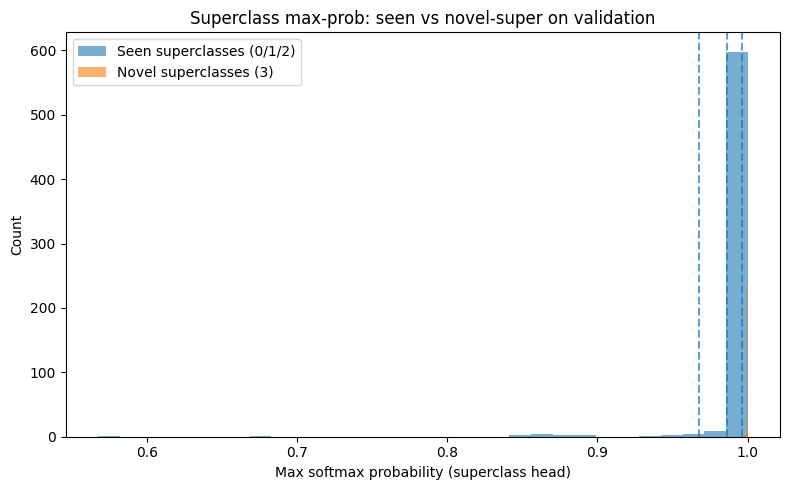

Logged superclass histograms and tau_super candidates to Weights & Biases.

=== Evaluation on val_super_only ===
Overall superclass acc: 0.9654
Seen superclass acc (true super != novel):   0.9379
Seen superclass false-novel rate:            0.0621
Novel superclass acc (true super == novel):  1.0000

=== Evaluation on val_sub_only ===
Overall subclass acc:   0.9264
Seen subclass acc (true sub != novel):       0.8678
Seen subclass false-novel rate:              0.1322
No pseudo_novel_loader available.

=== Evaluation on val ===
Overall superclass acc: 0.9654
Seen superclass acc (true super != novel):   0.9379
Seen superclass false-novel rate:            0.0621
Novel superclass acc (true super == novel):  1.0000

==== Novelty Dashboard ====
     Split   Head                             Metric  \
0   config      -                           APPROACH   
1   config      -                           BACKBONE   
2   config      -                   CIFAR_NOVEL_MODE   
3   config      -           

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
sub_train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
sub_val_acc,▁▃▅▆▆▇▆▅▆▅▆▆▆▆█
sub_val_loss,█▅▃▂▁▂▂▃▃▅▂▂▂▃▁
tau_super_candidate_1,▁
tau_super_candidate_2,▁
tau_super_candidate_3,▁
val_novel_super_acc,▁
val_overall_sub_acc,▁
val_overall_super_acc,▁
+11,...


In [ ]:
# Second idea to compare

LR = 1e-4

if APPROACH == "two_models":
    # Superclass model
    model_super = SingleHeadModel(num_classes=num_super).to(device)
    criterion_super = nn.CrossEntropyLoss()
    optimizer_super = setup_backbone_training(
        model_super,
        fine_tune_mode=FINE_TUNE_MODE,
        lr_full=LR,
        lr_head=LR_HEAD,
    )

    run_super = None
    if USE_WANDB:
        run_super = wandb.init(
            entity=WANDB_ENTITY,
            project=WANDB_PROJECT,
            name=make_run_name("two_models_super_resnet"),
            group="two_models",  # to filter all two_models runs together
            config={
                "approach": "two_models",
                "head": "super",
                "backbone": BACKBONE,
                "epochs": EPOCHS,
                "lr_full": LR,
                "lr_head": LR_HEAD,
                "fine_tune_mode": FINE_TUNE_MODE,
                "img_size": IMG_SIZE,
            },
        )

    best_val_super = 0.0

    print("Training superclass model:")
    for epoch in range(1, EPOCHS + 1):
        train_metrics = train_one_epoch(
            model_super,
            optimizer_super,
            train_loader,
            criterion_super,
            mode="single_head_super",
        )
        val_metrics = eval_one_epoch(
            model_super,
            val_loader,
            criterion_super,
            mode="single_head_super",
        )

        val_acc = val_metrics.get("val_acc_super", 0.0)
        print(
            f"[Super] Epoch {epoch}: "
            f"train_loss={train_metrics['loss']:.4f}, "
            f"val_loss={val_metrics['val_loss']:.4f}, "
            f"val_acc_super={val_acc:.4f}"
        )

        if USE_WANDB:
            wandb.log(
                {
                    "epoch": epoch,
                    "super_train_loss": train_metrics["loss"],
                    "super_val_loss": val_metrics["val_loss"],
                    "super_val_acc": val_acc,
                },
                step=epoch,
            )

        if val_acc > best_val_super:
            best_val_super = val_acc
            torch.save(
                model_super.state_dict(),
                os.path.join(DATA_ROOT, "best_super_model.pth"),
            )
            print("  Saved new best superclass model")

    if run_super is not None:
        run_super.finish()

    # Subclass model
    model_sub = SingleHeadModel(num_classes=num_sub).to(device)
    criterion_sub = nn.CrossEntropyLoss()
    optimizer_sub = setup_backbone_training(
        model_sub,
        fine_tune_mode=FINE_TUNE_MODE,
        lr_full=LR,
        lr_head=LR_HEAD,
    )

    run_sub = None
    if USE_WANDB:
        run_sub = wandb.init(
            entity=WANDB_ENTITY,
            project=WANDB_PROJECT,
            name=make_run_name("two_models_sub_resnet"),
            group="two_models",
            config={
                "approach": "two_models",
                "head": "sub",
                "backbone": BACKBONE,
                "epochs": EPOCHS,
                "lr_full": LR,
                "lr_head": LR_HEAD,
                "fine_tune_mode": FINE_TUNE_MODE,
                "img_size": IMG_SIZE,
            },
        )

    best_val_sub = 0.0

    print("\nTraining subclass model:")
    for epoch in range(1, EPOCHS + 1):
        train_metrics = train_one_epoch(
            model_sub,
            optimizer_sub,
            train_loader,
            criterion_sub,
            mode="single_head_sub",
        )
        val_metrics = eval_one_epoch(
            model_sub,
            val_loader,
            criterion_sub,
            mode="single_head_sub",
        )

        val_acc = val_metrics.get("val_acc_sub", 0.0)
        print(
            f"[Sub] Epoch {epoch}: "
            f"train_loss={train_metrics['loss']:.4f}, "
            f"val_loss={val_metrics['val_loss']:.4f}, "
            f"val_acc_sub={val_acc:.4f}"
        )

        if USE_WANDB:
            wandb.log(
                {
                    "epoch": epoch,
                    "sub_train_loss": train_metrics["loss"],
                    "sub_val_loss": val_metrics["val_loss"],
                    "sub_val_acc": val_acc,
                },
                step=epoch,
            )

        if val_acc > best_val_sub:
            best_val_sub = val_acc
            torch.save(
                model_sub.state_dict(),
                os.path.join(DATA_ROOT, "best_sub_model.pth"),
            )
            print("  Saved new best subclass model")

    best_super_path = os.path.join(DATA_ROOT, "best_super_model.pth")
    best_sub_path = os.path.join(DATA_ROOT, "best_sub_model.pth")
    model_super.load_state_dict(torch.load(best_super_path, map_location=device))
    model_sub.load_state_dict(torch.load(best_sub_path, map_location=device))

    analyze_tau_sub(model_sub, mode="sub_single_head")
    analyze_tau_super(model_super, mode="super_single_head")
    evaluate_on_val_with_novelty(
        model_super,
        mode="super_single_head",
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
        loader=val_loader,
        name="val_super_only",
    )
    evaluate_on_val_with_novelty(
        model_sub, mode="sub_single_head", tau_super=TAU_SUPER, tau_sub=TAU_SUB, loader=val_loader, name="val_sub_only"
    )
    evaluate_pseudo_novel_sub_with_novelty(model_sub, mode="sub_single_head", tau_sub=TAU_SUB)
    novelty_dashboard(
        model_super, mode="super_single_head", tau_super=TAU_SUPER, tau_sub=TAU_SUB, include_pseudo=False
    )  # no pseudo-novel meaning for super head
    novelty_dashboard(model_sub, mode="sub_single_head", tau_super=TAU_SUPER, tau_sub=TAU_SUB, include_pseudo=True)

    if run_sub is not None:
        run_sub.finish()

else:
    print("APPROACH is not 'two_models'; skipping two-model training in this cell.")

# SECTION 8: Test-time Inference & CSV Export for leaderboard **(two-head model)**

In [ ]:
# Inference in order to predict "novel" superclass / subclasses


@torch.no_grad()
def predict_test_two_heads(model, test_loader, tau_super=TAU_SUPER, tau_sub=TAU_SUB):
    """
    Inference for the two-heads model with novelty thresholds.

    model:       SharedBackboneTwoHeads(...)
    test_loader: DataLoader yielding (images, img_names)
    tau_super:   threshold for superclass novelty
    tau_sub:     threshold for subclass novelty
    """
    model.eval()
    images_list = []
    super_preds = []
    sub_preds = []

    for images, img_names in test_loader:
        images = images.to(device, non_blocking=True)

        # Forward pass once
        super_logits, sub_logits = model(images)  # (B, num_super), (B, num_sub)

        # --- Superclass predictions with novelty ---
        super_probs = F.softmax(super_logits, dim=1)  # (B, num_super)
        max_super_probs, super_idx = super_probs.max(dim=1)  # (B,)
        super_novel_mask = max_super_probs < tau_super
        super_idx = super_idx.clone()
        super_idx[super_novel_mask] = NOVEL_SUPER_IDX

        # --- Subclass predictions with novelty ---
        sub_probs = F.softmax(sub_logits, dim=1)  # (B, num_sub)
        max_sub_probs, sub_idx = sub_probs.max(dim=1)  # (B,)
        sub_novel_mask = max_sub_probs < tau_sub
        sub_idx = sub_idx.clone()
        sub_idx[sub_novel_mask] = NOVEL_SUB_IDX

        # Move to CPU as plain Python ints
        super_idx = super_idx.cpu().tolist()
        sub_idx = sub_idx.cpu().tolist()

        # img_names is a list of filenames (len = B)
        images_list.extend(img_names)
        super_preds.extend(super_idx)
        sub_preds.extend(sub_idx)

    df = pd.DataFrame({"image": images_list, "superclass_index": super_preds, "subclass_index": sub_preds})
    return df


# SECTION: Test-time inference & CSV export for two-heads model

if APPROACH == "two_heads":
    # Recreate the model and load best checkpoint
    model_two_heads = SharedBackboneTwoHeads(num_super=num_super, num_sub=num_sub).to(device)
    best_ckpt_path = os.path.join(DATA_ROOT, "best_two_heads_kl.pth")
    model_two_heads.load_state_dict(torch.load(best_ckpt_path, map_location=device))

    test_predictions = predict_test_two_heads(
        model_two_heads,
        test_loader,
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
    )
    out_csv_path = os.path.join(DATA_ROOT, "two_heads_predictions.csv")
    test_predictions.to_csv(out_csv_path, index=False)
    print("Saved two-heads predictions (with novelty) to:", out_csv_path)
else:
    print("APPROACH is not 'two_heads'; skipping two-heads inference in this cell.")

APPROACH is not 'two_heads'; skipping two-heads inference in this cell.


# SECTION 9: Test-time Inference & CSV Export for leaderboard **(two separate models)**

In [ ]:
@torch.no_grad()
def predict_test_two_models(model_super, model_sub, test_loader, tau_super=TAU_SUPER, tau_sub=TAU_SUB):
    """
    Inference for the two-model setup (separate super + sub models) with novelty thresholds.

    model_super: SingleHeadModel for superclass (num_classes = num_super)
    model_sub:   SingleHeadModel for subclass  (num_classes = num_sub)
    test_loader: DataLoader yielding (images, img_names)
    tau_super:   threshold for superclass novelty
    tau_sub:     threshold for subclass novelty
    """

    model_super.eval()
    model_sub.eval()

    images_list = []
    super_preds = []
    sub_preds = []

    for images, img_names in test_loader:
        images = images.to(device, non_blocking=True)

        # Forward passes
        super_logits = model_super(images)  # (B, num_super)
        sub_logits = model_sub(images)  # (B, num_sub)

        # --- Superclass predictions with novelty ---
        super_probs = F.softmax(super_logits, dim=1)  # (B, num_super)
        max_super_probs, super_idx = super_probs.max(dim=1)  # (B,)
        super_novel_mask = max_super_probs < tau_super
        super_idx = super_idx.clone()
        super_idx[super_novel_mask] = NOVEL_SUPER_IDX

        # --- Subclass predictions with novelty ---
        sub_probs = F.softmax(sub_logits, dim=1)  # (B, num_sub)
        max_sub_probs, sub_idx = sub_probs.max(dim=1)  # (B,)
        sub_novel_mask = max_sub_probs < tau_sub
        sub_idx = sub_idx.clone()
        sub_idx[sub_novel_mask] = NOVEL_SUB_IDX

        # Move indices to CPU as plain Python ints
        super_idx = super_idx.cpu().tolist()
        sub_idx = sub_idx.cpu().tolist()

        # img_names is a list of filenames (len = B)
        images_list.extend(img_names)
        super_preds.extend(super_idx)
        sub_preds.extend(sub_idx)

    df = pd.DataFrame(
        {
            "image": images_list,
            "superclass_index": super_preds,
            "subclass_index": sub_preds,
        }
    )
    return df


if APPROACH == "two_models":
    model_super = SingleHeadModel(num_classes=num_super).to(device)
    model_sub = SingleHeadModel(num_classes=num_sub).to(device)

    model_super.load_state_dict(torch.load(os.path.join(DATA_ROOT, "best_super_model.pth"), map_location=device))
    model_sub.load_state_dict(torch.load(os.path.join(DATA_ROOT, "best_sub_model.pth"), map_location=device))

    test_predictions_two_models = predict_test_two_models(
        model_super,
        model_sub,
        test_loader,
        tau_super=TAU_SUPER,
        tau_sub=TAU_SUB,
    )

    out_csv_path = os.path.join(DATA_ROOT, "two_models_predictions.csv")
    test_predictions_two_models.to_csv(out_csv_path, index=False)
    print("Saved two-model predictions (with novelty) to:", out_csv_path)

else:
    print("APPROACH is not 'two_models'; skipping two-models inference in this cell.")

Saved two-model predictions (with novelty) to: /content/drive/MyDrive/NNDL-Project/Project Data/two_models_predictions.csv
